In [1]:
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
%matplotlib inline


## Одна из проблем градиентных методов - <font color=red>негладкие функции</font>, а также "застревание" в локальных минимумах

Можно решать с помощью рандомизированных алгоритмов: в выборе следующего приближения будет участвовать некоторая "разумная случайность". Можно рассчитывать, что "случайность" будет бороться с локальными минимумами ("жадностью" алгоритма).<br>
Один из классических алгоритмов негладкой оптимизации - <font color=blue>метод имитации отжига</font>

## Алгоритм имитации отжига
Основная идея:
 - Определяем функцию "мутации" аргумента $mut(x)$
 - Фиксируем начальное значение "температуры"
 - Итеративно применяем мутации к предыдущему приближению, причем вероятность принятия локально неоптимальной мутации положительна и зависит от текущей температуры
 - С каждой итерацией температура уменьшается

**Более формально:**
- Хотим найти минимум некоторой функции $f$
- В зависимости от задачи определяем функцию мутации $mut$, например $mut(x) = x + \varepsilon$, где $\varepsilon$ - некоторое небольшое случайное число
- Фиксируем начальное значение температуры $T_0=100$
- Фиксируем "коэффициент остывания" $0<\alpha <1$
- Фиксируем начальное приближение решения $x_0$
- На каждом шаге итерации алгоритма определяем кандидата в решение: $x_{cand}^{t+1}=mut(x^t)$
- Считаем разность $df:=f(x_{cand}^{t+1}) - f(x^t)$ - это то, насколько значение в мутированной точке отличается от значения на предыдущем шаге
- Интуиция: если $df$ "сильно отрицательно", то новый кандидат существенно лучше предыдущего приближения
- Если $df<0$, то полагаем $x^{t+1} := x_{cand}^{t+1}$ и считаем нового кандидата (предварительно уменьшив температуру: $T_{t+1}=\alpha\cdot T_t$)
- Если $df>=0$, то вычисляем $p = \exp\left({-\cfrac{df}{T_k}}\right)$
- С вероятностью $p$ принимаем $x^{t+1} := x_{cand}^{t+1}$. Именно здесь мы поступаем <font color=red>нежадным</font> образом!
- С вероятностью $1-p$ принимаем $x^{t+1} := x^{t}$
- Уменьшаем температуру $T_{t+1}=\alpha\cdot T_t$ и переходим к вычислению нового кандидата
<br><br>
Таким образом,  у нас всегда есть вероятность выбрать неоптимальное решение (причем, чем "хуже" очередной кандидат в решение, тем меньше эта вероятность, а также эта вероятность стабильно уменьшается по мере работы алгоритма ("эффект остывания").<br>
**Нигде не используется гладкость $f$! <br>
Всё, что нужно - уметь вычислять $f$ в любой точке. Никаких ограничений.**


## <font color=blue> Пример применения алгоритма: задача о ферзях</font> 
Для шахматной доски $N \times N$ требуется найти расстановку $N$ ферзей, так, чтобы они не били друг друга.
<br><br>
Каждое решение можно закодировать в виде перестановки на множестве $[1,2,3,\cdots,N]$, где число $j$ на $i$-ой позиции обозначает, что в $i$-ом столбце стоит ферзь на $j$-ой сверху строке. 

### Создаём класс, отвечающий за шахматную доску размера $N\times N$.
В этот класс входит:
- информация о размере поля и текущем решении (инициализируется в виде списка $[1,2,3,\ldots,N]$)
- метод для мутации текущего решения
- метод для вычисления функции потерь для произвольного кандидата в решение
- метод для вычисления функции потерь на текущем решении
- метод для обновления текущего решения

In [2]:

class chess_board():
    
    def __init__(self, N): # метод, который вызывается, когда мы первый раз создаём представителя класса
        
        self.N = N # размер доски
        self.Pos = list(np.arange(self.N)) # начальное приближение к решению
            
    def mutation(self): # мутация - это случайная перестановка двух элементов
        
        Pos = self.Pos.copy()
        i = 0
        j = 0
        while i == j: # Находим два случайных несовпадающих индекса
            i = rnd.randint(0, self.N - 1)
            j = rnd.randint(0, self.N - 1)
        
        # меняем их местами (удобная фишка Python):
        Pos[i], Pos[j] = Pos[j], Pos[i]

        return Pos
        
    def loss(self, Pos): # вычисление целевой функции на кандидате в решение Pos: сколько ферзей находится под ударом
        
        loss = 0
        for n in range(self.N):
            k = n - 1
            while k >= 0:
                if Pos[k] == (Pos[n] + (n - k)):
                    loss = loss + 1

                if Pos[k] == (Pos[n] - (n - k)):
                    loss = loss + 1
                k = k - 1

            k = n + 1
            while k < self.N:
                if Pos[k] == (Pos[n] + (k - n)):
                    loss = loss + 1

                if Pos[k] == (Pos[n] - (k - n)):
                    loss = loss + 1
                k = k + 1
                
        return loss

    def loss_current(self): # вычисление текущего значения функции
        return self.loss(self.Pos)
    
    def update_solution(self, Pos): # обновление текущего приближения к решению
        self.Pos = Pos
        


## Создаём класс, описывающий шаг работы алгоритма имитации отжига
В этот класс входит:
- Инициализация гиперпараметров алгоритма: начальная температура и коэффициент остывания
- Метод для шага алгоритма отжига (обновляет текущее решение и вычисляет текущее значение функции потерь)

In [3]:
# Класс, описывающий шаг работы алгоритма + инициализация параметров алгоритма

class algorithm_step():
    def __init__(self, chess_board):
        self.board = chess_board # инициализируем шахматную доску
        
        self.T = 50 # начальная температура
        self.alpha = 0.95 # коэффициент "остывания"
        
    def Step(self): # один шаг алгоритма
        Pos = self.board.mutation() # мутируем текущее решение
        df = self.board.loss(Pos) - self.board.loss_current() # насколько значение функции потерь уменьшилось на кандидате
        
        if df < 0: # если есть улучшение
            self.board.update_solution(Pos) # принимаем текущего кандидата
        else:
            p = np.exp(- df / self.T) # считаем вероятность
            
            if p > rnd.random(): # то же самое, что вероятность того, что случайная точка с отрезка [0,1] попала в подотрезок [0,p]
                self.board.update_solution(Pos) # принимаем локально неоптимальное решение
                
            # "else" нет, т.е. остаемся при старом приближении решения

            self.T = self.alpha * self.T # уменьшаем температуру

        return self.board.loss_current() # возвращаем текущее значение функции потерь

## Запускаем алгоритм на доске $8\times 8$

[4, 1, 3, 9, 6, 8, 0, 2, 7, 5]


Text(0, 0.5, 'Loss')

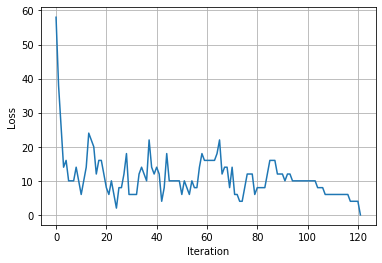

In [20]:
board = chess_board(10) # размерность доски

step = algorithm_step(board) # инициализируем алгоритм

Curs = list() # сюда будем записывать текущие решения

for n in range(1000):
    cur = step.Step() # шаг алгоритма: обновляем решение и возвращаем текущее значение целевой функции
    Curs.append(cur)
    
    if cur == 0:
        print(board.Pos)
        break

plt.plot(Curs)
plt.grid(True)
plt.xlabel("Iteration")
plt.ylabel("Loss")

## Определим функцию отрисовки текущего решения на шахматной доске

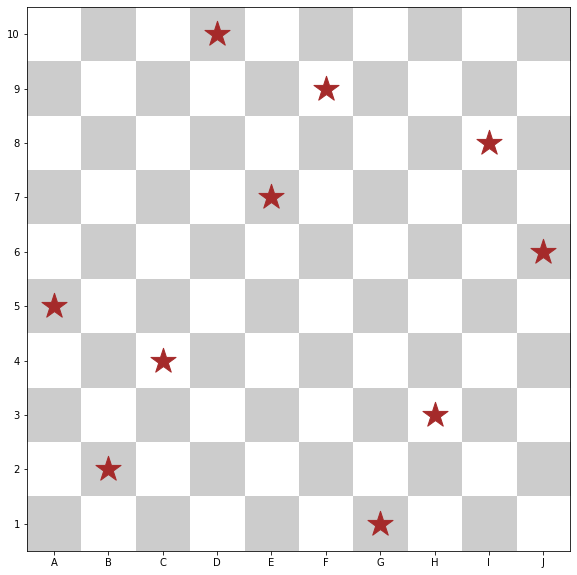

In [21]:
alphabet = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']

def plot_solution(Pos):
    N = len(Pos)
    x = np.arange(1,N+1,1)-1
    y = N - np.array(Pos)-1
    
    a = np.arange(1, N+1, 1)
    b = np.arange(1, N+1, 1)
    X, Y = np.meshgrid(a, b)
    
    plt.figure(figsize=(N,N))

    Z1 = 1-(np.add.outer(range(N), range(N)) % 2)  # эта хитрая штука отрисовывает фон шахматной доски
    im1 = plt.imshow(Z1, cmap=plt.cm.gray, interpolation='nearest', alpha=0.2)

    plt.xticks(np.arange(N+1),alphabet[:N]) # ось X подписываем алфавитом
    plt.yticks(np.arange(N+1),np.arange(N,0,-1)) # Нумерация снизу вверх
    plt.scatter(x,y,color='brown',marker='*',s=700)

plot_solution(board.Pos)